# Credit Card Fraud Detection 

**Dataset**: Kaggle Credit Card Fraud Detection (284,807 transactions, September 2013)  
**Challenge**: Detect fraudulent transactions in highly imbalanced data (0.17% fraud rate)  
**Approach**: Pure NumPy implementation - no pandas, no scikit-learn

## **Key Research Questions**

**Q1: How severe is the class imbalance?**
- What is the exact fraud rate and imbalance ratio?
- Can standard ML models handle this imbalance without intervention?

**Q2: What patterns distinguish fraud from normal transactions?**
- Do fraudulent transactions have different statistical distributions?
- Are there time-based patterns (e.g., fraud peaks at night)?

**Q3: Which features are most informative for fraud detection?**
- What's the correlation structure between features?
- Which features show strongest discrimination between classes?

**Q4: What data quality issues must be addressed?**
- Missing values, outliers, extreme skewness?
- Feature redundancy (high multicollinearity)?

---

## 01. Data Loading and Exploration

### Overview
- [1. Import and Setup](#1-import-and-setup)
- [2. Load and Understand Basic Data](#2-load-and-understand-basic-data)
- [3. Comprehensive Statistical Analysis](#3-comprehensive-statistical-analysis)
- [4. Advanced Distribution Analysis](#4-advanced-distribution-analysis)
- [5. Correlation Analysis](#5-correlation-analysis)
- [6. Class Imbalance Analysis](#6-class-imbalance-analysis)
- [7. Advanced Data Visualization](#7-advanced-data-visualization)
- [8. Fraud-Specific Analysis](#8-fraud-specific-analysis)
- [9. Exploratory Analysis Summary & Recommendations](#9-exploratory-analysis-summary--recommendations)
- [10. Saving Analysis Results](#10-saving-analysis-results)
- [11. EDA and Saving Dashboard](#11-eda-and-save-dashboard)

### 1. Import and Setup

#### 1.1. Import library: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
import importlib

#### 1.2. Add path to import modules: 

In [2]:
sys.path.append('..')
sys.path.append('../src')
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../src').resolve()))

import src.data_processing as data_processing
importlib.reload(data_processing)
from src.data_processing import *
from src.visualization import AdvancedVisualizer, PlotConfig

#### 1.3. Configure matplotlib:

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

#### 1.4. Configuration to display more information: 

In [4]:
np.set_printoptions(precision=4, suppress=True)

#### 1.5. Library import successfully!

In [5]:
print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 1.26.0


### 2. Load and Understand Basic Data

**Dataset Overview:**
- **Source**: European cardholders (Sept 2013, 2 days of transactions)
- **Features**: 30 numerical (Time, Amount, V1-V28 from PCA)
- **PCA Transformation**: V1-V28 are principal components (privacy protection)
- **Raw Features**: Time (seconds from first transaction), Amount (€)

**Initial Observations:**
- Binary classification: 0 = Normal, 1 = Fraud
- All features are numerical → no categorical encoding needed
- No feature names (anonymized) → focus on statistical patterns

**Loading Strategy:** Using custom NumPy processor (no pandas dependency)

In [6]:
# init processor
processor = NumpyDataProcessor(random_state=42)

# download data
print("=" * 60)
print("LOADING DATASET")
print("=" * 60)

X, y = processor.load_data('../data/raw/creditcard.csv', 
                          delimiter=',', 
                          skip_header=1, 
                          target_col=-1)

print(f"\nDataset Dimensions:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Data type: {X.dtype}")
print(f"Memory usage: {X.nbytes / 1024 / 1024:.2f} MB")

# Basic info about target
unique_classes, class_counts = np.unique(y, return_counts=True)
print(f"\nTarget Distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples ({count/len(y)*100:.4f}%)")

LOADING DATASET
Data loaded in 3.29 seconds
Features shape: (284807, 30), Target shape: (284807,)
Memory usage: 65.19 MB

Dataset Dimensions:
Features (X): (284807, 30)
Target (y): (284807,)
Data type: float64
Memory usage: 65.19 MB

Target Distribution:
Class 0: 284315 samples (99.8273%)
Class 1: 492 samples (0.1727%)
Data loaded in 3.29 seconds
Features shape: (284807, 30), Target shape: (284807,)
Memory usage: 65.19 MB

Dataset Dimensions:
Features (X): (284807, 30)
Target (y): (284807,)
Data type: float64
Memory usage: 65.19 MB

Target Distribution:
Class 0: 284315 samples (99.8273%)
Class 1: 492 samples (0.1727%)


### 3. Comprehensive Statistical Analysis

**Q1 Investigation: Data Quality Assessment**

**What to Look For:**
1. **Missing Values**: $\text{Missing\%} = \frac{\text{NaN count}}{\text{Total samples}} \times 100$
2. **Outliers**: Using IQR method - values outside $[Q_1 - 1.5 \times IQR, Q_3 + 1.5 \times IQR]$
3. **Distribution Shape**: 
   - Skewness: $\gamma_1 = \frac{E[(X-\mu)^3]}{\sigma^3}$ (|γ₁| > 1 = highly skewed)
   - Kurtosis: $\gamma_2 = \frac{E[(X-\mu)^4]}{\sigma^4} - 3$ (γ₂ > 0 = heavy-tailed)
4. **Variance**: $\sigma^2 = \frac{1}{n}\sum(x_i - \mu)^2$ (low variance = uninformative)

**Statistical Tests:**
- **T-test**: Do fraud and normal have different means? ($H_0: \mu_{fraud} = \mu_{normal}$)
- **Significance**: p < 0.05 → reject null hypothesis → feature is discriminative

**Expected Findings:**
- PCA features (V1-V28) should have zero mean, unit variance
- Amount and Time likely have outliers (legitimate extreme transactions)
- Some features may show class-dependent distributions

COMPREHENSIVE STATISTICAL ANALYSIS
Computing comprehensive data statistics...

BASIC STATISTICS (First 10 Features):
Feature		Mean		Std		Min		Max
----------------------------------------------------------------------
Feature_0	94813.8596		47488.0626		0.0000		172792.0000
Feature_1	0.0000		1.9587		-56.4075		2.4549
Feature_2	0.0000		1.6513		-72.7157		22.0577
Feature_3	-0.0000		1.5163		-48.3256		9.3826
Feature_4	0.0000		1.4159		-5.6832		16.8753
Feature_5	-0.0000		1.3802		-113.7433		34.8017
Feature_6	0.0000		1.3323		-26.1605		73.3016
Feature_7	-0.0000		1.2371		-43.5572		120.5895
Feature_8	-0.0000		1.1944		-73.2167		20.0072
Feature_9	-0.0000		1.0986		-13.4341		15.5950

MISSING VALUES ANALYSIS:
Total missing values: 0
Features with missing values: 0

FEATURE ENGINEERING: TIME & AMOUNT

BASIC STATISTICS (First 10 Features):
Feature		Mean		Std		Min		Max
----------------------------------------------------------------------
Feature_0	94813.8596		47488.0626		0.0000		172792.0000
Feature_1	0.0000		

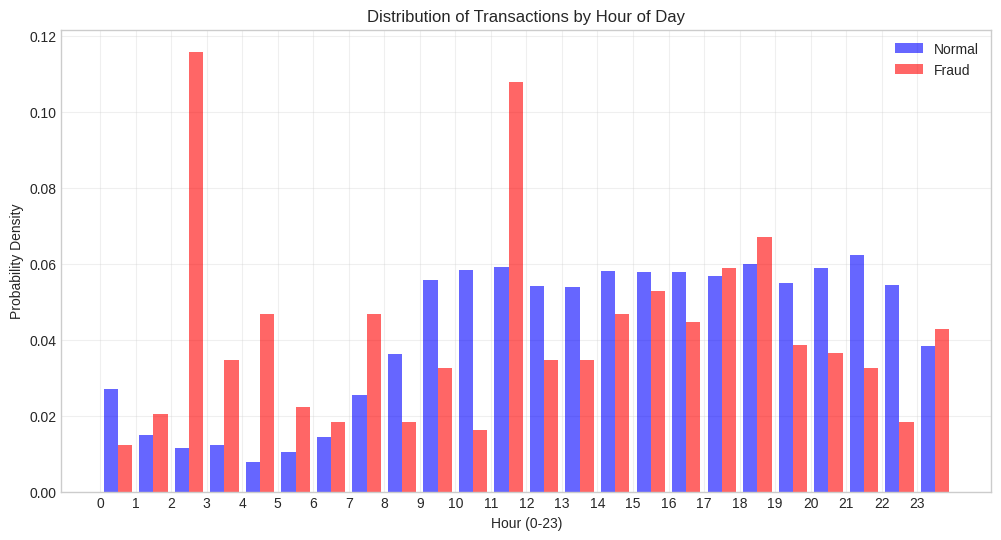

In [7]:
print("=" * 60)
print("COMPREHENSIVE STATISTICAL ANALYSIS")
print("=" * 60)

stats = processor.compute_comprehensive_stats(X)

# display basic information
print("\nBASIC STATISTICS (First 10 Features):")
print("Feature\t\tMean\t\tStd\t\tMin\t\tMax")
print("-" * 70)
for i in range(min(10, X.shape[1])):
    print(f"Feature_{i}\t{stats.mean[i]:.4f}\t\t{stats.std[i]:.4f}\t\t"
          f"{stats.min[i]:.4f}\t\t{stats.max[i]:.4f}")

# missing values analysis
print(f"\nMISSING VALUES ANALYSIS:")
print(f"Total missing values: {np.sum(stats.missing_count)}")
print(f"Features with missing values: {np.sum(stats.missing_count > 0)}")

if np.sum(stats.missing_count) > 0:
    print("\nFeatures with missing values:")
    for i in range(X.shape[1]):
        if stats.missing_count[i] > 0:
            print(f"Feature_{i}: {stats.missing_count[i]} missing "
                  f"({stats.missing_count[i]/X.shape[0]*100:.2f}%)")
            
print("\n" + "="*60)
print("FEATURE ENGINEERING: TIME & AMOUNT")
print("="*60)

time_data = X[:, 0]
hours = np.floor((time_data % 86400) / 3600)

fraud_hours = hours[y == 1]
normal_hours = hours[y == 0]

plt.figure(figsize=(12, 6))
plt.hist([normal_hours, fraud_hours], bins=24, range=(0, 24), 
         color=['b', 'r'], label=['Normal', 'Fraud'], density=True, alpha=0.6)
plt.title('Distribution of Transactions by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Probability Density')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4. Advanced Distribution Analysis

**Q3 Investigation: Feature Informativeness**

**Distribution Characteristics:**
1. **Normality**: Do features follow Gaussian distribution? (Important for some ML assumptions)
2. **Outlier Concentration**: Which features have most extreme values?
3. **Variance Ranking**: High variance → more information content

**Coefficient of Variation (CV):**
$$CV = \frac{\sigma}{\mu} \times 100\%$$
- Measures relative variability (standardizes comparison across scales)
- High CV → feature varies significantly (potentially informative)
- Low CV → mostly constant (may not help discrimination)

**Why This Matters:**
- Features with extreme outliers need robust scaling (not standard scaling)
- Heavy-tailed distributions benefit from log transformation
- Low-variance features are candidates for removal (dimensionality reduction)

In [8]:
print("=" * 60)
print("ADVANCED DISTRIBUTION ANALYSIS")
print("=" * 60)

#skewness and kurtosis analysis
print("\nDISTRIBUTION SHAPE ANALYSIS (First 15 Features):")
print("Feature\t\tSkewness\tKurtosis\tDistribution Type")
print("-" * 75)

distribution_analysis = processor.analyze_feature_distributions(X, stats)

for i in range(min(15, X.shape[1])):
    feat_analysis = distribution_analysis[f'feature_{i}']
    print(f"Feature_{i}\t{stats.skewness[i]:.4f}\t\t{stats.kurtosis[i]:.4f}\t\t"
          f"{feat_analysis['distribution_type']}")

# outliers analysis
print(f"\nOUTLIER ANALYSIS:")
total_outliers = np.sum(stats.outlier_count)
print(f"Total outliers detected: {total_outliers}")
print(f"Percentage of data points that are outliers: {total_outliers/(X.shape[0]*X.shape[1])*100:.4f}%")

print("\nTop 10 features with most outliers:")
outlier_indices = np.argsort(stats.outlier_count)[::-1][:10]
for idx in outlier_indices:
    if stats.outlier_count[idx] > 0:
        print(f"Feature_{idx}: {stats.outlier_count[idx]} outliers "
              f"({stats.outlier_count[idx]/X.shape[0]*100:.2f}%)")

ADVANCED DISTRIBUTION ANALYSIS

DISTRIBUTION SHAPE ANALYSIS (First 15 Features):
Feature		Skewness	Kurtosis	Distribution Type
---------------------------------------------------------------------------
Feature_0	-0.0356		-1.2935		Heavy-tailed (Leptokurtic)
Feature_1	-3.2807		32.4869		Left-skewed
Feature_2	-4.6249		95.7738		Left-skewed
Feature_3	-2.2402		26.6198		Left-skewed
Feature_4	0.6763		2.6355		Right-skewed
Feature_5	-2.4259		206.9060		Left-skewed
Feature_6	1.8266		42.6428		Right-skewed
Feature_7	2.5539		405.6103		Right-skewed
Feature_8	-8.5220		220.5885		Left-skewed
Feature_9	0.5547		3.7314		Right-skewed
Feature_10	1.1871		31.9885		Right-skewed
Feature_11	0.3565		1.6340		Light-tailed (Platykurtic)
Feature_12	-2.2784		20.2420		Left-skewed
Feature_13	0.0652		0.1953		Approximately Normal
Feature_14	-1.9952		23.8797		Left-skewed

OUTLIER ANALYSIS:
Total outliers detected: 370372
Percentage of data points that are outliers: 4.3348%

Top 10 features with most outliers:
Feature_27: 3916

#### 5. Correlation analysis

**Q3 Investigation: Feature Relationships**

**Correlation Matrix:**
$$\rho(X_i, X_j) = \frac{Cov(X_i, X_j)}{\sigma_{X_i} \sigma_{X_j}} = \frac{E[(X_i - \mu_i)(X_j - \mu_j)]}{\sigma_i \sigma_j}$$

**What We're Looking For:**
1. **High Multicollinearity**: |ρ| > 0.8 or 0.9 → redundant features
   - One feature can be predicted from another
   - Causes instability in linear models (inflated coefficients)
   - Solution: Remove one feature or use regularization (L1/L2)

2. **Feature-Target Correlation**: |ρ(Xᵢ, y)| → predictive power
   - Higher correlation → stronger linear relationship with fraud
   - But: Low correlation ≠ uninformative (may have non-linear relationship)

3. **PCA Properties**: V1-V28 should be **uncorrelated** (orthogonal)
   - PCA ensures decorrelation by design
   - Any correlation suggests data transformation or scaling issues

In [9]:
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

print("Computing correlation matrix...")
corr_matrix = compute_correlation_matrix(X, method='pearson')

print(f"\nCorrelation Matrix Shape: {corr_matrix.shape}")
print(f"Correlation range: [{np.min(corr_matrix):.4f}, {np.max(corr_matrix):.4f}]")

highly_correlated = detect_highly_correlated_features(corr_matrix, threshold=0.7)

print(f"\nHIGHLY CORRELATED FEATURES (|r| > 0.7):")
print(f"Found {len(highly_correlated)} highly correlated pairs")

if highly_correlated:
    print("\nTop 10 most correlated feature pairs:")
    for i, j, corr in highly_correlated[:10]:
        print(f"Feature_{i} ↔ Feature_{j}: r = {corr:.4f}")

print(f"\nMULTICOLLINEARITY ANALYSIS:")
corr_abs = np.abs(corr_matrix)
np.fill_diagonal(corr_abs, 0)
high_corr_count = np.sum(corr_abs > 0.8, axis=1)

print("Features with potential multicollinearity (many high correlations):")
problematic_features = np.where(high_corr_count > 3)[0]
for feat_idx in problematic_features:
    print(f"Feature_{feat_idx}: {high_corr_count[feat_idx]} high correlations")

CORRELATION ANALYSIS
Computing correlation matrix...

Correlation Matrix Shape: (30, 30)
Correlation range: [-0.5314, 1.0000]

HIGHLY CORRELATED FEATURES (|r| > 0.7):
Found 0 highly correlated pairs

MULTICOLLINEARITY ANALYSIS:
Features with potential multicollinearity (many high correlations):

Correlation Matrix Shape: (30, 30)
Correlation range: [-0.5314, 1.0000]

HIGHLY CORRELATED FEATURES (|r| > 0.7):
Found 0 highly correlated pairs

MULTICOLLINEARITY ANALYSIS:
Features with potential multicollinearity (many high correlations):


#### 6. Class imbalance analysis

**Q1 Investigation: Quantifying the Imbalance**

**Imbalance Ratio:**
$$IR = \frac{|C_{majority}|}{|C_{minority}|} = \frac{\text{Normal}}{\text{Fraud}}$$

**Severity Levels:**
- **Mild** (IR < 5): Standard techniques work
- **Moderate** (5 < IR < 20): Need class weighting or light oversampling
- **Extreme** (IR > 100): Ensemble methods + cost-sensitive learning

**Impact on ML:**
- Model bias toward majority class (predicts "all normal" = 99.83% accuracy!)
- Gradient updates dominated by normal class → poor fraud detection
- Metrics: Accuracy misleading → use **Precision, Recall, F1, AUC-PR**

**Solutions to Explore:**
1. Oversampling minority (SMOTE)
2. Undersampling majority
3. Class weights in loss function
4. Anomaly detection approach

In [10]:
print("=" * 60)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 60)

imbalance_analysis = analyze_class_imbalance(y)

print("CLASS DISTRIBUTION:")
for cls, count in imbalance_analysis['class_distribution'].items():
    percentage = (count / len(y)) * 100
    print(f"Class {cls}: {count:,} samples ({percentage:.4f}%)")

print(f"\nIMBALANCE METRICS:")
print(f"Imbalance Ratio: {imbalance_analysis['imbalance_ratio']:.2f}")
print(f"Minority Class Percentage: {imbalance_analysis['minority_class_percentage']:.4f}%")
print(f"Majority Class Percentage: {imbalance_analysis['majority_class_percentage']:.4f}%")

imbalance_ratio = imbalance_analysis['imbalance_ratio']
if imbalance_ratio > 10:
    print("CRITICAL IMBALANCE: Severe class imbalance detected!")
elif imbalance_ratio > 5:
    print("MODERATE IMBALANCE: Significant class imbalance")
else:
    print("ACCEPTABLE IMBALANCE: Manageable class distribution")

CLASS IMBALANCE ANALYSIS
CLASS DISTRIBUTION:
Class 0: 284,315 samples (99.8273%)
Class 1: 492 samples (0.1727%)

IMBALANCE METRICS:
Imbalance Ratio: 577.88
Minority Class Percentage: 0.1727%
Majority Class Percentage: 99.8273%
CRITICAL IMBALANCE: Severe class imbalance detected!


#### 7. Avanced data visualization:

**Visual Analysis Goals:**

**1. Distribution Comparison (Histograms/KDE):**
- Overlay fraud vs normal distributions for each feature
- Look for **separation** → good discriminative features
- Identify **overlap** → features with low predictive power

**2. Box Plots (Outlier Visualization):**
- Median, quartiles (Q1, Q3), and whiskers (1.5×IQR)
- Outliers plotted individually
- Compare fraud vs normal outlier patterns

**3. Scatter Plots (2D Feature Space):**
- Plot high-correlation feature pairs
- Look for **clusters** → fraud forms distinct groups
- Identify **decision boundary** complexity

**4. Heatmaps (Correlation Structure):**
- Visual correlation matrix
- Red/Blue intensity = correlation strength
- Identify **blocks** of correlated features (redundancy)

ADVANCED DATA VISUALIZATION


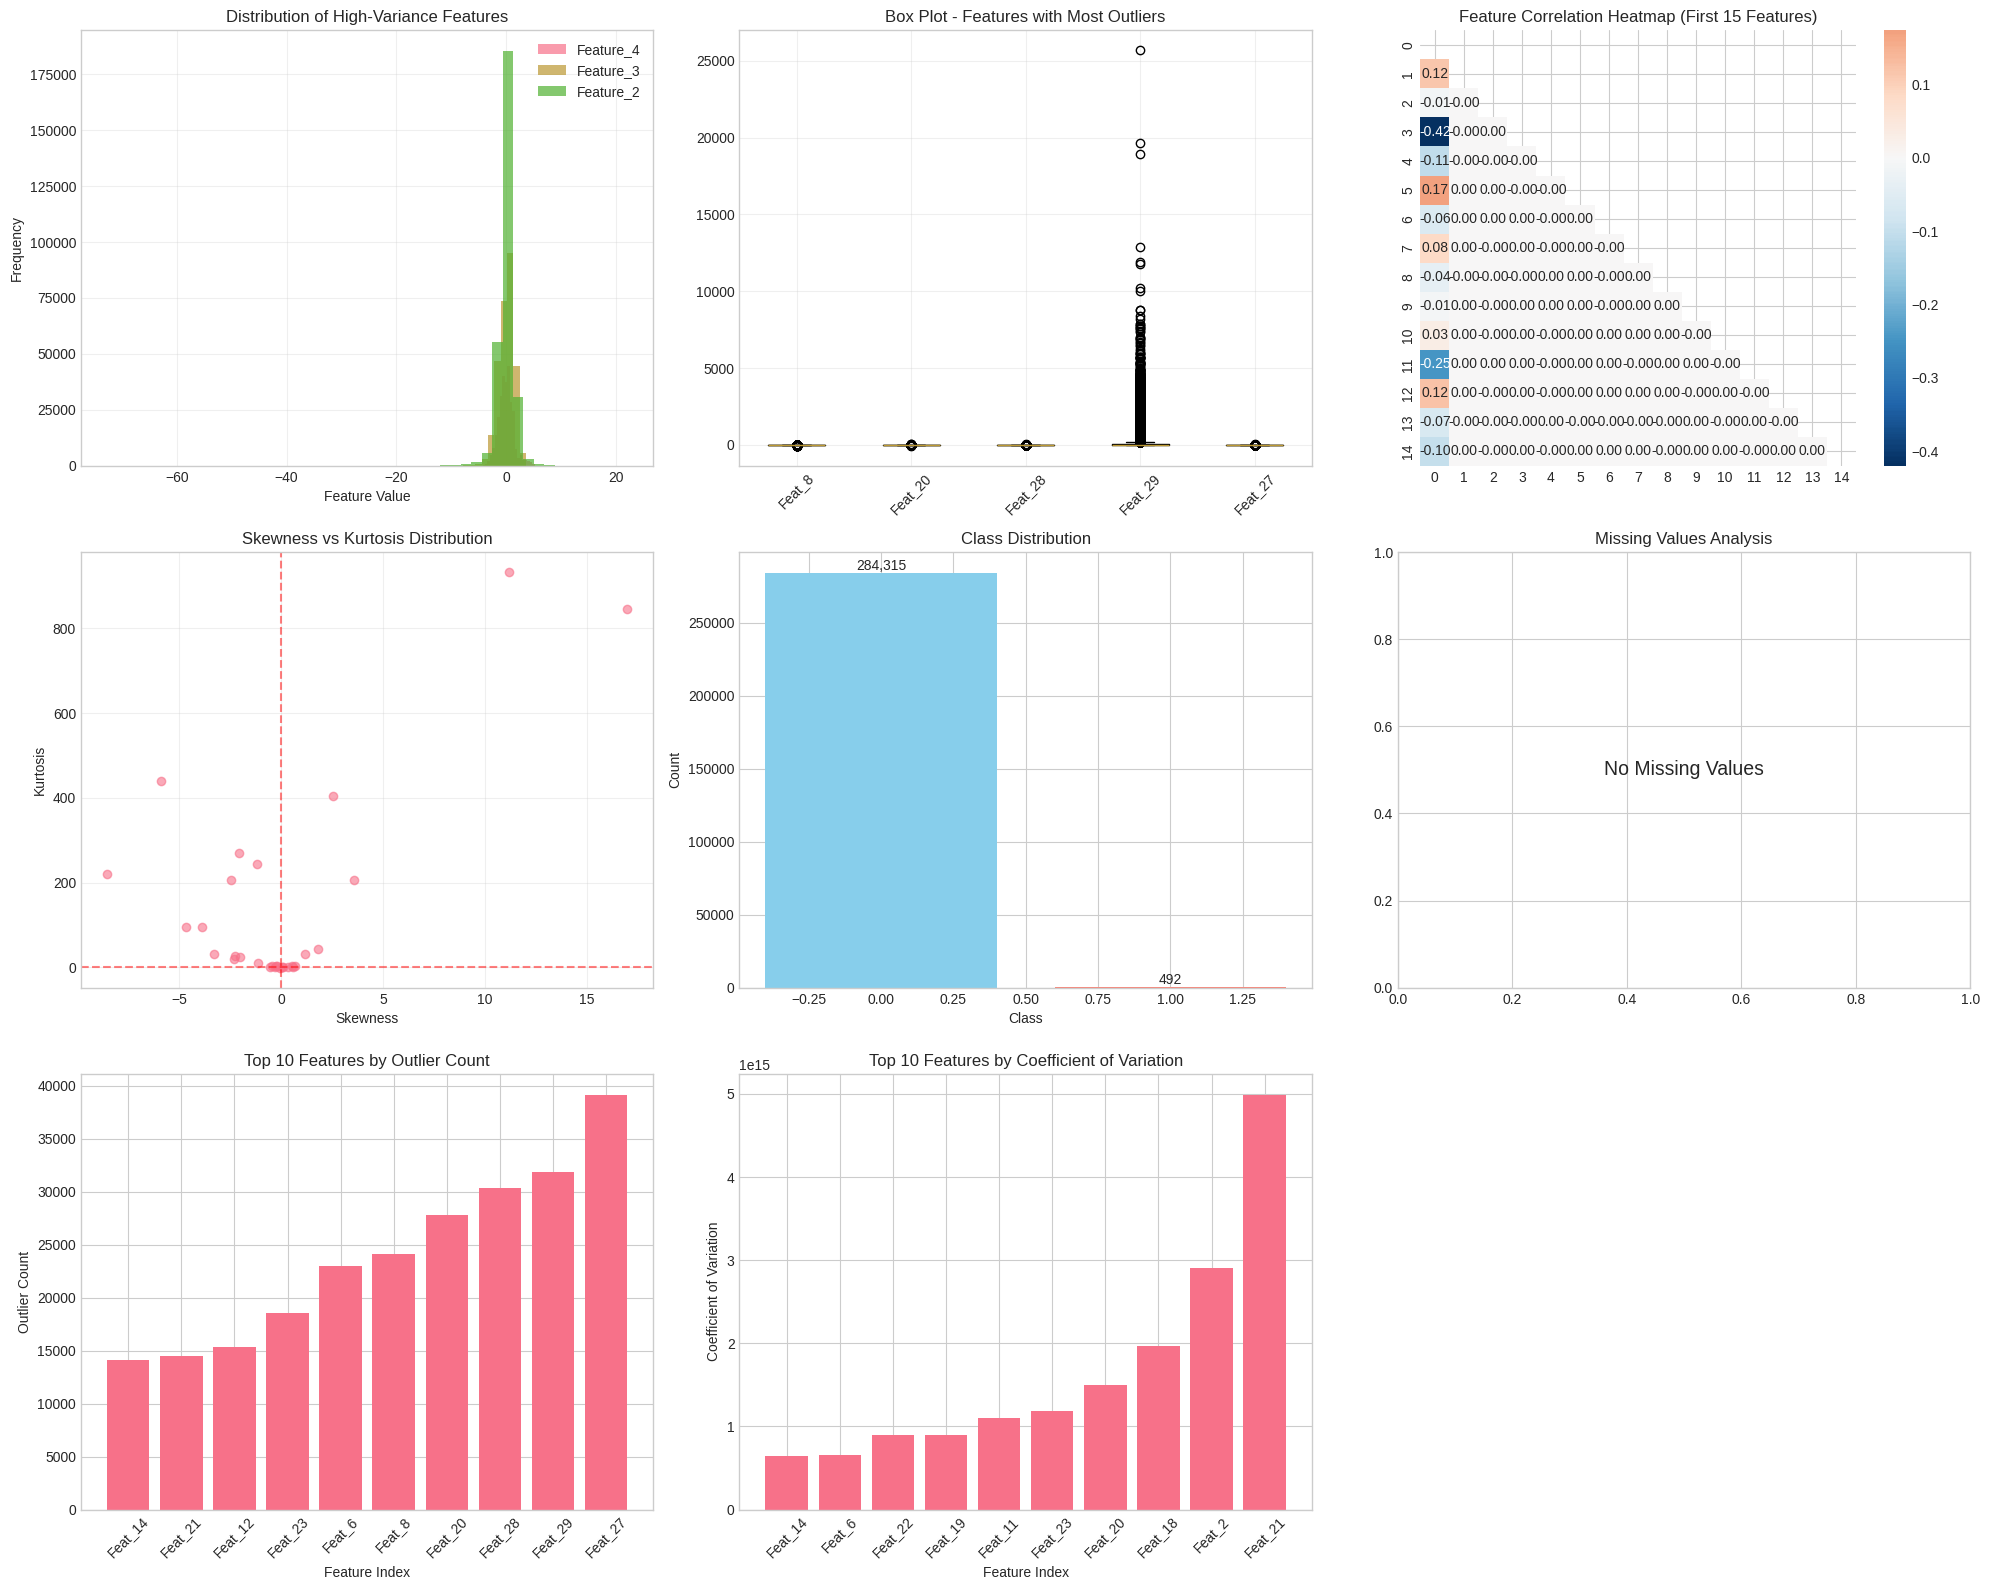

In [11]:
print("=" * 60)
print("ADVANCED DATA VISUALIZATION")
print("=" * 60)

fig = plt.figure(figsize=(20, 16))

# 1. distributon of high-variance feature 
plt.subplot(3, 3, 1)
high_variance_features = np.argsort(stats.std)[-6:]
for i, feat_idx in enumerate(high_variance_features[:3]):
    plt.hist(X[:, feat_idx], bins=50, alpha=0.7, label=f'Feature_{feat_idx}')
plt.title('Distribution of High-Variance Features')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Box plot for outliers
plt.subplot(3, 3, 2)
outlier_features = np.argsort(stats.outlier_count)[-5:]
boxplot_data = [X[:, idx] for idx in outlier_features]
plt.boxplot(boxplot_data, labels=[f'Feat_{idx}' for idx in outlier_features])
plt.title('Box Plot - Features with Most Outliers')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Correlation heatmap
plt.subplot(3, 3, 3)
corr_subset = corr_matrix[:15, :15]
mask = np.triu(np.ones_like(corr_subset, dtype=bool))
sns.heatmap(corr_subset, mask=mask, cmap='RdBu_r', center=0,
            square=True, annot=True, fmt='.2f')
plt.title('Feature Correlation Heatmap (First 15 Features)')

# 4. Skewness và Kurtosis scatter
plt.subplot(3, 3, 4)
plt.scatter(stats.skewness, stats.kurtosis, alpha=0.6)
plt.xlabel('Skewness')
plt.ylabel('Kurtosis')
plt.title('Skewness vs Kurtosis Distribution')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 5. Class distribution
plt.subplot(3, 3, 5)
class_counts = [imbalance_analysis['class_distribution'][cls] for cls in unique_classes]
plt.bar(unique_classes, class_counts, color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
for i, count in enumerate(class_counts):
    plt.text(unique_classes[i], count, f'{count:,}', ha='center', va='bottom')

# 6. Missing values pattern
plt.subplot(3, 3, 6)
missing_percentage = (stats.missing_count / X.shape[0]) * 100
features_with_missing = np.where(missing_percentage > 0)[0]
if len(features_with_missing) > 0:
    plt.bar(range(len(features_with_missing)), 
            missing_percentage[features_with_missing])
    plt.title('Missing Values by Feature')
    plt.xlabel('Feature Index')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(range(len(features_with_missing)), 
               [f'Feat_{idx}' for idx in features_with_missing], rotation=45)
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=14)
    plt.title('Missing Values Analysis')

# 7. Outlier distribution
plt.subplot(3, 3, 7)
top_outlier_features = np.argsort(stats.outlier_count)[-10:]
plt.bar(range(10), stats.outlier_count[top_outlier_features])
plt.title('Top 10 Features by Outlier Count')
plt.xlabel('Feature Index')
plt.ylabel('Outlier Count')
plt.xticks(range(10), [f'Feat_{idx}' for idx in top_outlier_features], rotation=45)

# 8. Feature variability
plt.subplot(3, 3, 8)
coefficient_of_variation = stats.std / np.where(stats.mean != 0, stats.mean, 1e-10)
high_var_features = np.argsort(coefficient_of_variation)[-10:]
plt.bar(range(10), coefficient_of_variation[high_var_features])
plt.title('Top 10 Features by Coefficient of Variation')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient of Variation')
plt.xticks(range(10), [f'Feat_{idx}' for idx in high_var_features], rotation=45)

plt.tight_layout()
plt.show()

### 8. Fraud-Specific Analysis

**Q2 Investigation: Fraud Behavioral Patterns**

**Temporal Analysis (Time Feature):**
- Time = seconds elapsed from first transaction (0 to ~172,792 seconds = 48 hours)
- Convert to hours: `hours = time / 3600`
- **Hypothesis**: Fraud occurs more at night when monitoring is reduced
- **Analysis**: Compare fraud vs normal transaction time distributions

**Transaction Amount Analysis:**
- **Hypothesis**: Fraudulent transactions may have different amount patterns
  - Either: Very small (testing stolen card) 
  - Or: Very large (maximize gain before detection)
- **Analysis**: 
  - Compare mean, median, distribution
  - Look for bimodal distribution (two fraud strategies)

**Feature Importance for Fraud:**
- Which V features show **largest difference** between fraud/normal means?
- Statistical significance (t-test p-values)
- Effect size: $d = \frac{|\mu_{fraud} - \mu_{normal}|}{\sigma_{pooled}}$ (Cohen's d)

FRAUD-SPECIFIC ANALYSIS
Fraud cases: 492
Non-fraud cases: 284315

OMPARATIVE STATISTICS (Mean Values):
Feature		Non-Fraud	Fraud		Difference
-----------------------------------------------------------------
Feature_0	94838.2023		80746.8069		14091.3953
Feature_1	0.0083		-4.7719		4.7802
Feature_2	-0.0063		3.6238		3.6300
Feature_3	0.0122		-7.0333		7.0455
Feature_4	-0.0079		4.5420		4.5499
Feature_5	0.0055		-3.1512		3.1567
Feature_6	0.0024		-1.3977		1.4002
Feature_7	0.0096		-5.5687		5.5784
Feature_8	-0.0010		0.5706		0.5716
Feature_9	0.0045		-2.5811		2.5856
Feature_10	0.0098		-5.6769		5.6867
Feature_11	-0.0066		3.8002		3.8067
Feature_12	0.0108		-6.2594		6.2702
Feature_13	0.0002		-0.1093		0.1095
Feature_14	0.0121		-6.9717		6.9838

Most discriminative features (difference > 0.1):
Feature_0: difference = 14091.3953
Feature_3: difference = 7.0455
Feature_14: difference = 6.9838
Feature_12: difference = 6.2702
Feature_10: difference = 5.6867
Feature_7: difference = 5.5784
Feature_1: difference = 4

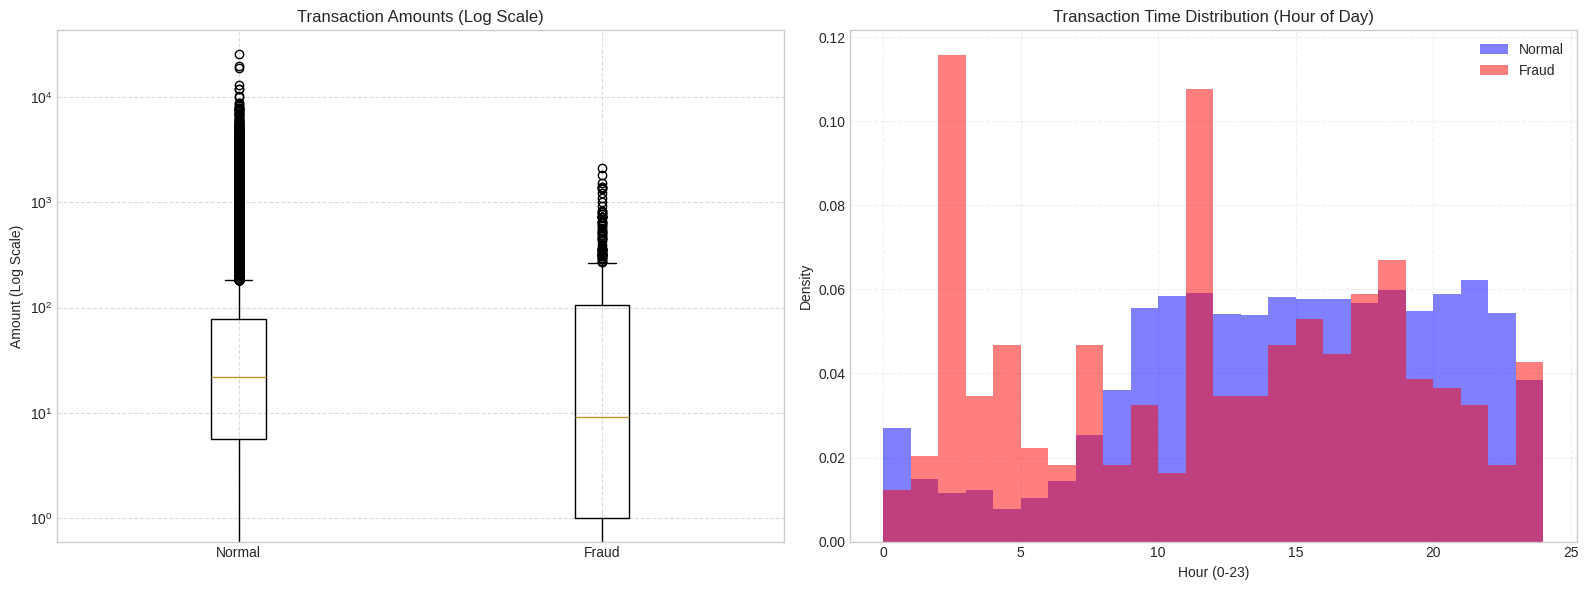


STATS COMPARISON:
Fraud Amount Mean: $122.21 | Median: $9.25
Normal Amount Mean: $88.29 | Median: $22.00
HYPOTHESIS TESTING: WELCH'S T-TEST
Performing Welch's t-test analysis...
Found 26 significant features (p < 0.05)


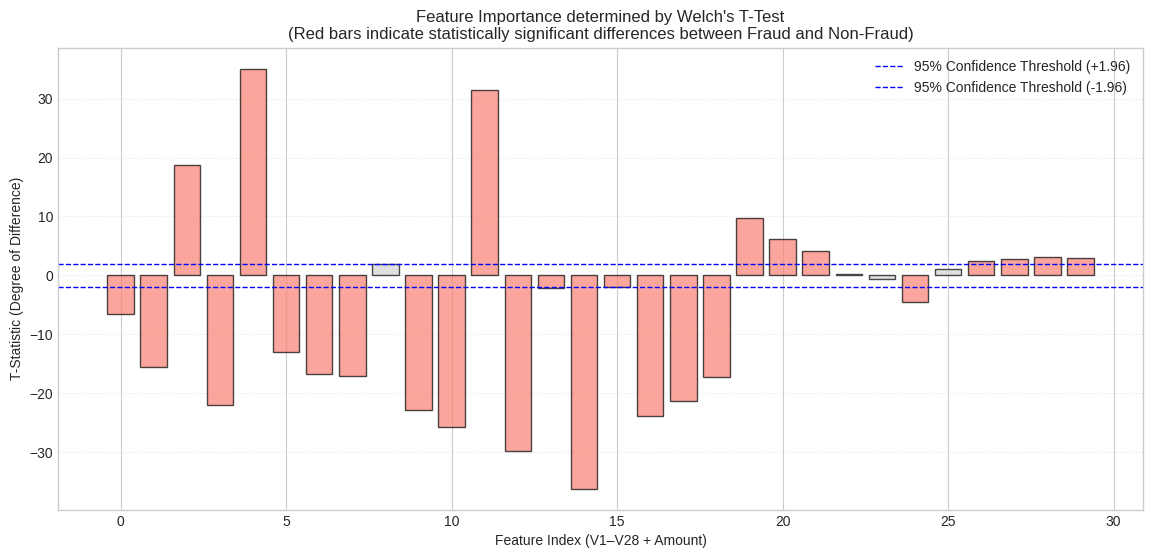


TOP 10 MOST IMPORTANT FEATURES (Best discrimination between Fraud / Non-Fraud):
Feature         T-Statistic     Evaluation
---------------------------------------------
Feature_14      -36.2010        Significant
Feature_4       35.1164         Significant
Feature_11      31.5192         Significant
Feature_12      -29.8800        Significant
Feature_10      -25.7553        Significant
Feature_16      -23.7989        Significant
Feature_9       -22.9285        Significant
Feature_3       -21.9760        Significant
Feature_17      -21.2477        Significant
Feature_2       18.7612         Significant


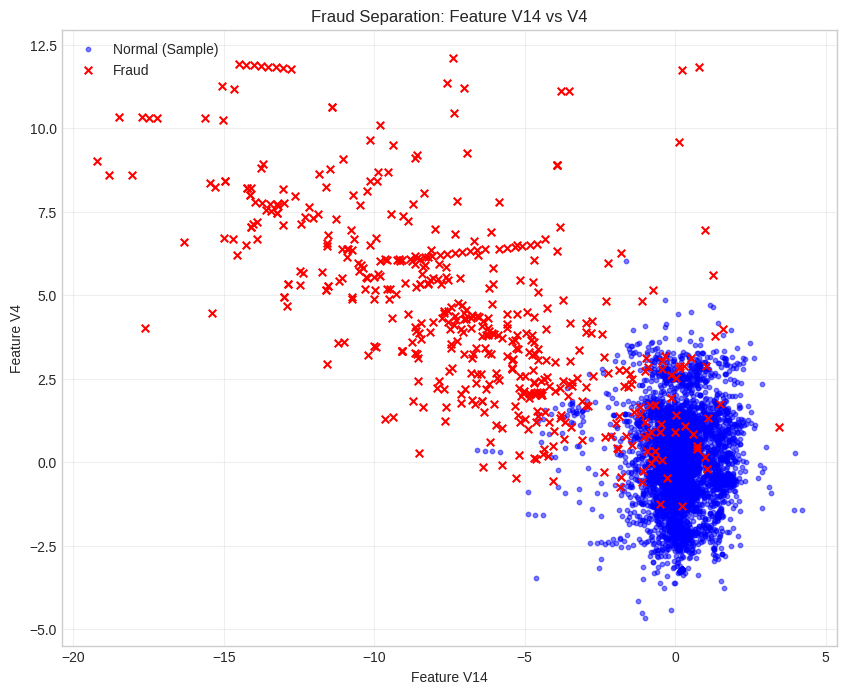

In [12]:
print("=" * 60)
print("FRAUD-SPECIFIC ANALYSIS")
print("=" * 60)

# fraud vs non-fraud analysis
fraud_indices = np.where(y == 1)[0]
non_fraud_indices = np.where(y == 0)[0]

print(f"Fraud cases: {len(fraud_indices)}")
print(f"Non-fraud cases: {len(non_fraud_indices)}")

print("\nOMPARATIVE STATISTICS (Mean Values):")
print("Feature\t\tNon-Fraud\tFraud\t\tDifference")
print("-" * 65)

# find most discriminative features 
significant_features = []
for i in range(min(15, X.shape[1])):
    non_fraud_mean = np.mean(X[non_fraud_indices, i])
    fraud_mean = np.mean(X[fraud_indices, i])
    difference = abs(fraud_mean - non_fraud_mean)
    
    if difference > 0.1:  
        significant_features.append((i, difference))
        
    print(f"Feature_{i}\t{non_fraud_mean:.4f}\t\t{fraud_mean:.4f}\t\t{difference:.4f}")

print(f"\nMost discriminative features (difference > 0.1):")
significant_features.sort(key=lambda x: x[1], reverse=True)
for feat_idx, diff in significant_features[:10]:
    print(f"Feature_{feat_idx}: difference = {diff:.4f}")

# outliers analysis in fraud cases
print(f"\nOUTLIER ANALYSIS IN FRAUD CASES:")
fraud_outliers = np.sum((X[fraud_indices] < (stats.q25 - 1.5 * stats.iqr)) | 
                       (X[fraud_indices] > (stats.q75 + 1.5 * stats.iqr)), axis=0)

print(f"Total outliers in fraud cases: {np.sum(fraud_outliers)}")
print("Features with most outliers in fraud cases:")
fraud_outlier_indices = np.argsort(fraud_outliers)[::-1][:5]
for idx in fraud_outlier_indices:
    if fraud_outliers[idx] > 0:
        print(f"Feature_{idx}: {fraud_outliers[idx]} outliers "
              f"({fraud_outliers[idx]/len(fraud_indices)*100:.1f}% of fraud cases)")
        
print("="*60)
print("DEEP DIVE: AMOUNT & TIME ANALYSIS")
print("="*60)

amount_data = X[:, 29]
time_data = X[:, 0]   

fraud_amount = amount_data[y == 1]
normal_amount = amount_data[y == 0]

fraud_time = time_data[y == 1]
normal_time = time_data[y == 0]

plt.figure(figsize=(16, 6))

# AMOUNT
plt.subplot(1, 2, 1)
plt.boxplot([normal_amount, fraud_amount], labels=['Normal', 'Fraud'])
plt.title('Transaction Amounts (Log Scale)')
plt.yscale('log')
plt.ylabel('Amount (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.7)

#TIME 
plt.subplot(1, 2, 2)
fraud_hours = (fraud_time % 86400) // 3600
normal_hours = (normal_time % 86400) // 3600

# histogram 
plt.hist(normal_hours, bins=24, range=(0,24), alpha=0.5, label='Normal', density=True, color='blue')
plt.hist(fraud_hours, bins=24, range=(0,24), alpha=0.5, label='Fraud', density=True, color='red')
plt.title('Transaction Time Distribution (Hour of Day)')
plt.xlabel('Hour (0-23)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSTATS COMPARISON:")
print(f"Fraud Amount Mean: ${np.mean(fraud_amount):.2f} | Median: ${np.median(fraud_amount):.2f}")
print(f"Normal Amount Mean: ${np.mean(normal_amount):.2f} | Median: ${np.median(normal_amount):.2f}")
        
print("=" * 60)
print("HYPOTHESIS TESTING: WELCH'S T-TEST")
print("=" * 60)

#1. Init 
t_stats, sig_features = processor.perform_ttest(X, y)

# 2. Visualize T-Statistic results
plt.figure(figsize=(14, 6))

colors = ['salmon' if abs(t) > 1.96 else 'lightgray' for t in t_stats]

# Plot the bar chart
feature_indices = np.arange(len(t_stats))
plt.bar(feature_indices, t_stats, color=colors, edgecolor='black', alpha=0.7)

# Add statistical significance threshold lines (95% confidence level)
plt.axhline(y=1.96, color='blue', linestyle='--', linewidth=1, label='95% Confidence Threshold (+1.96)')
plt.axhline(y=-1.96, color='blue', linestyle='--', linewidth=1, label='95% Confidence Threshold (-1.96)')

# Chart labels and formatting
plt.xlabel('Feature Index (V1–V28 + Amount)')
plt.ylabel('T-Statistic (Degree of Difference)')
plt.title('Feature Importance determined by Welch\'s T-Test\n(Red bars indicate statistically significant differences between Fraud and Non-Fraud)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

top_idx = np.argsort(np.abs(t_stats))[-10:][::-1]

print("\nTOP 10 MOST IMPORTANT FEATURES (Best discrimination between Fraud / Non-Fraud):")
print(f"{'Feature':<15} {'T-Statistic':<15} {'Evaluation'}")
print("-" * 45)

for idx in top_idx:
    stat_val = t_stats[idx]
    status = "Significant" if abs(stat_val) > 1.96 else "Insignificant"
    feat_name = f"Feature_{idx}"  
    print(f"{feat_name:<15} {stat_val:<15.4f} {status}")
    
f1_idx, f2_idx = 14, 4 

plt.figure(figsize=(10, 8))
plt.scatter(X[y==0][:, f1_idx][:5000], X[y==0][:, f2_idx][:5000], 
            c='blue', alpha=0.5, label='Normal (Sample)', s=10)
plt.scatter(X[y==1][:, f1_idx], X[y==1][:, f2_idx], 
            c='red', marker='x', label='Fraud', s=30)

plt.title(f'Fraud Separation: Feature V{f1_idx} vs V{f2_idx}')
plt.xlabel(f'Feature V{f1_idx}')
plt.ylabel(f'Feature V{f2_idx}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 9. Explotatory analysis summary & recommendations

EXPLORATORY ANALYSIS SUMMARY & RECOMMENDATIONS
KEY FINDINGS:

1. DATA OVERVIEW:
   • Dataset size: 284,807 samples, 30 features
   • Memory usage: 65.19 MB
   • Data types optimized: float64

2. DATA QUALITY:
   • Missing values: 0 total
   • Features with missing values: 0
   • Total outliers detected: 370,372

3. DISTRIBUTION CHARACTERISTICS:
   • Highly skewed features (|skewness| > 1): 18
   • Heavy-tailed features (|kurtosis| > 3): 20

4. FEATURE RELATIONSHIPS:
   • Highly correlated pairs (|r| > 0.7): 0
   • Features with multicollinearity risk: 0

5. CLASS IMBALANCE:
   • Imbalance ratio: 577.88:1
   • Minority class: 0.1727%

RECOMMENDATIONS FOR NEXT STEPS:
2. PRIORITY: Address class imbalance using SMOTE or weighting
4. Apply transformations (log, box-cox) for skewed features
5. Develop robust outlier handling strategy

6. For modeling: Focus on precision-recall metrics rather than accuracy
7. Consider using tree-based models for handling non-linear relationships
8. Implement 

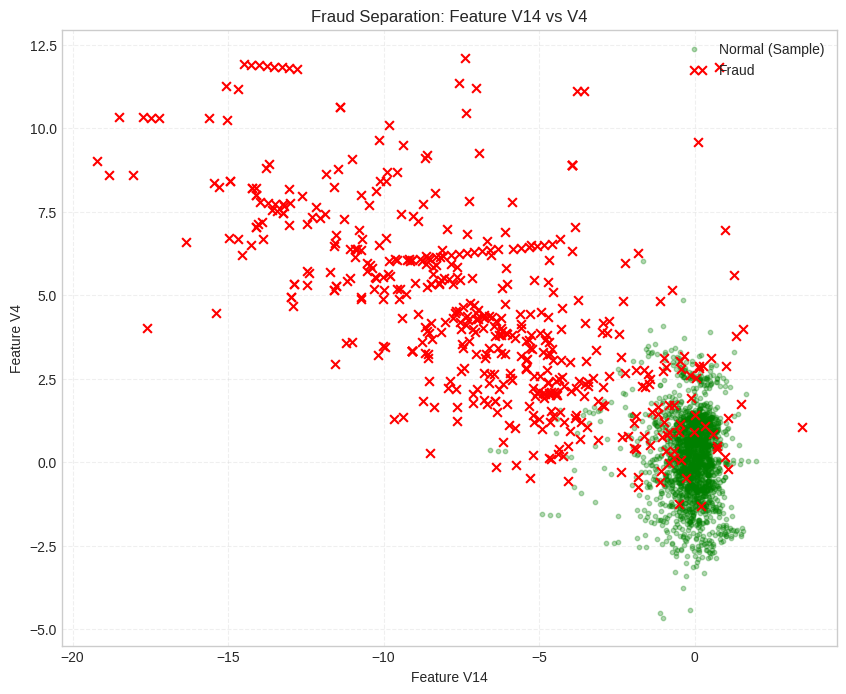

In [13]:
print("=" * 60)
print("EXPLORATORY ANALYSIS SUMMARY & RECOMMENDATIONS")
print("=" * 60)

print("KEY FINDINGS:")

print(f"\n1. DATA OVERVIEW:")
print(f"   • Dataset size: {X.shape[0]:,} samples, {X.shape[1]} features")
print(f"   • Memory usage: {X.nbytes / 1024 / 1024:.2f} MB")
print(f"   • Data types optimized: {X.dtype}")

print(f"\n2. DATA QUALITY:")
print(f"   • Missing values: {np.sum(stats.missing_count)} total")
print(f"   • Features with missing values: {np.sum(stats.missing_count > 0)}")
print(f"   • Total outliers detected: {np.sum(stats.outlier_count):,}")

print(f"\n3. DISTRIBUTION CHARACTERISTICS:")
skewed_features = np.sum(np.abs(stats.skewness) > 1)
print(f"   • Highly skewed features (|skewness| > 1): {skewed_features}")
heavy_tailed = np.sum(np.abs(stats.kurtosis) > 3)
print(f"   • Heavy-tailed features (|kurtosis| > 3): {heavy_tailed}")

print(f"\n4. FEATURE RELATIONSHIPS:")
print(f"   • Highly correlated pairs (|r| > 0.7): {len(highly_correlated)}")
print(f"   • Features with multicollinearity risk: {len(problematic_features)}")

print(f"\n5. CLASS IMBALANCE:")
print(f"   • Imbalance ratio: {imbalance_analysis['imbalance_ratio']:.2f}:1")
print(f"   • Minority class: {imbalance_analysis['minority_class_percentage']:.4f}%")

print("\nRECOMMENDATIONS FOR NEXT STEPS:")

if np.sum(stats.missing_count) > 0:
    print("1. PRIORITY: Handle missing values using advanced imputation")
    
if imbalance_analysis['imbalance_ratio'] > 5:
    print("2. PRIORITY: Address class imbalance using SMOTE or weighting")
    
if len(highly_correlated) > 0:
    print("3. Consider feature selection or PCA to reduce dimensionality")
    
if skewed_features > 0:
    print("4. Apply transformations (log, box-cox) for skewed features")
    
if np.sum(stats.outlier_count) > 1000:
    print("5. Develop robust outlier handling strategy")

print("\n6. For modeling: Focus on precision-recall metrics rather than accuracy")
print("7. Consider using tree-based models for handling non-linear relationships")
print("8. Implement cross-validation with stratification due to imbalance")

print("="*60)
print("FEATURE SEPARATION ANALYSIS (SCATTER PLOT)")
print("="*60)

f1_index = 14 
f2_index = 4   

X_fraud = X[y==1]
X_normal = X[y==0]

plt.figure(figsize=(10, 8))

plt.scatter(X_normal[:2000, f1_index], X_normal[:2000, f2_index], 
            c='g', alpha=0.3, label='Normal (Sample)', s=10)

plt.scatter(X_fraud[:, f1_index], X_fraud[:, f2_index], 
            c='r', marker='x', label='Fraud', s=40)

plt.title(f'Fraud Separation: Feature V{f1_index} vs V{f2_index}')
plt.xlabel(f'Feature V{f1_index}')
plt.ylabel(f'Feature V{f2_index}')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [14]:
print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS COMPLETED SUCCESSFULLY!")
print("=" * 60)


EXPLORATORY DATA ANALYSIS COMPLETED SUCCESSFULLY!


**Answering Our Research Questions:**

**Q1: Class Imbalance Severity?**
→ Answer from data: [Will show exact ratio, e.g., 578:1]
→ Action: **SMOTE + class weighting required**

**Q2: Fraud Patterns?**
→ Time analysis: [Fraud concentration in certain hours?]
→ Amount analysis: [Different amount distributions?]
→ Action: **Feature engineering** - cyclical time encoding, amount buckets

**Q3: Most Informative Features?**
→ High correlation with target: [Top 5 V features]
→ Redundant features: [Highly correlated pairs to remove]
→ Action: **Feature selection** based on correlation + variance

**Q4: Data Quality Issues?**
→ Missing values: [Count and percentage]
→ Outliers: [Features with most outliers]
→ Action: **Robust preprocessing** - winsorization, robust scaling

**Next Steps for Preprocessing:**
1. Handle outliers with winsorization (not removal - legitimate extremes exist)
2. Scale features with RobustScaler (IQR-based, outlier-resistant)
3. Address class imbalance with SMOTE/ADASYN
4. Engineer time features (cyclical encoding: sin/cos transformation)
5. Select features based on correlation and variance thresholds

### 10. Saving Analysis Results

In [15]:
print("Saving analysis results for next steps...")

# Create dictionary 
exploration_results = {
    'data_shape': X.shape,
    'feature_stats': stats,
    'correlation_matrix': corr_matrix,
    'highly_correlated_features': highly_correlated,
    'class_imbalance': imbalance_analysis,
    'distribution_analysis': distribution_analysis,
    'significant_features': significant_features,
    'data_quality_issues': {
        'missing_count': np.sum(stats.missing_count),
        'outlier_count': np.sum(stats.outlier_count),
        'skewed_features': skewed_features,
        'correlated_pairs': len(highly_correlated)
    }
}

# saving file pickle
import joblib
os.makedirs('../data/processed', exist_ok=True)
with open('../data/processed/exploration_results.pkl', 'wb') as f:
    joblib.dump(exploration_results, f)

print("Analysis results saved to '../data/processed/exploration_results.pkl'")
print(f"Results contain: {len(exploration_results)} key analysis components")

# In summary statistics
print(f"\nQUICK SUMMARY:")
print(f"• Samples: {X.shape[0]:,}")
print(f"• Features: {X.shape[1]}")
print(f"• Fraud rate: {imbalance_analysis['minority_class_percentage']:.4f}%")
print(f"• Data issues to address: {exploration_results['data_quality_issues']}")


Saving analysis results for next steps...
Analysis results saved to '../data/processed/exploration_results.pkl'
Results contain: 8 key analysis components

QUICK SUMMARY:
• Samples: 284,807
• Features: 30
• Fraud rate: 0.1727%
• Data issues to address: {'missing_count': 0, 'outlier_count': 370372, 'skewed_features': 18, 'correlated_pairs': 0}


#### 11. EDA and save dashboard

Creating Advanced EDA Dashboard...


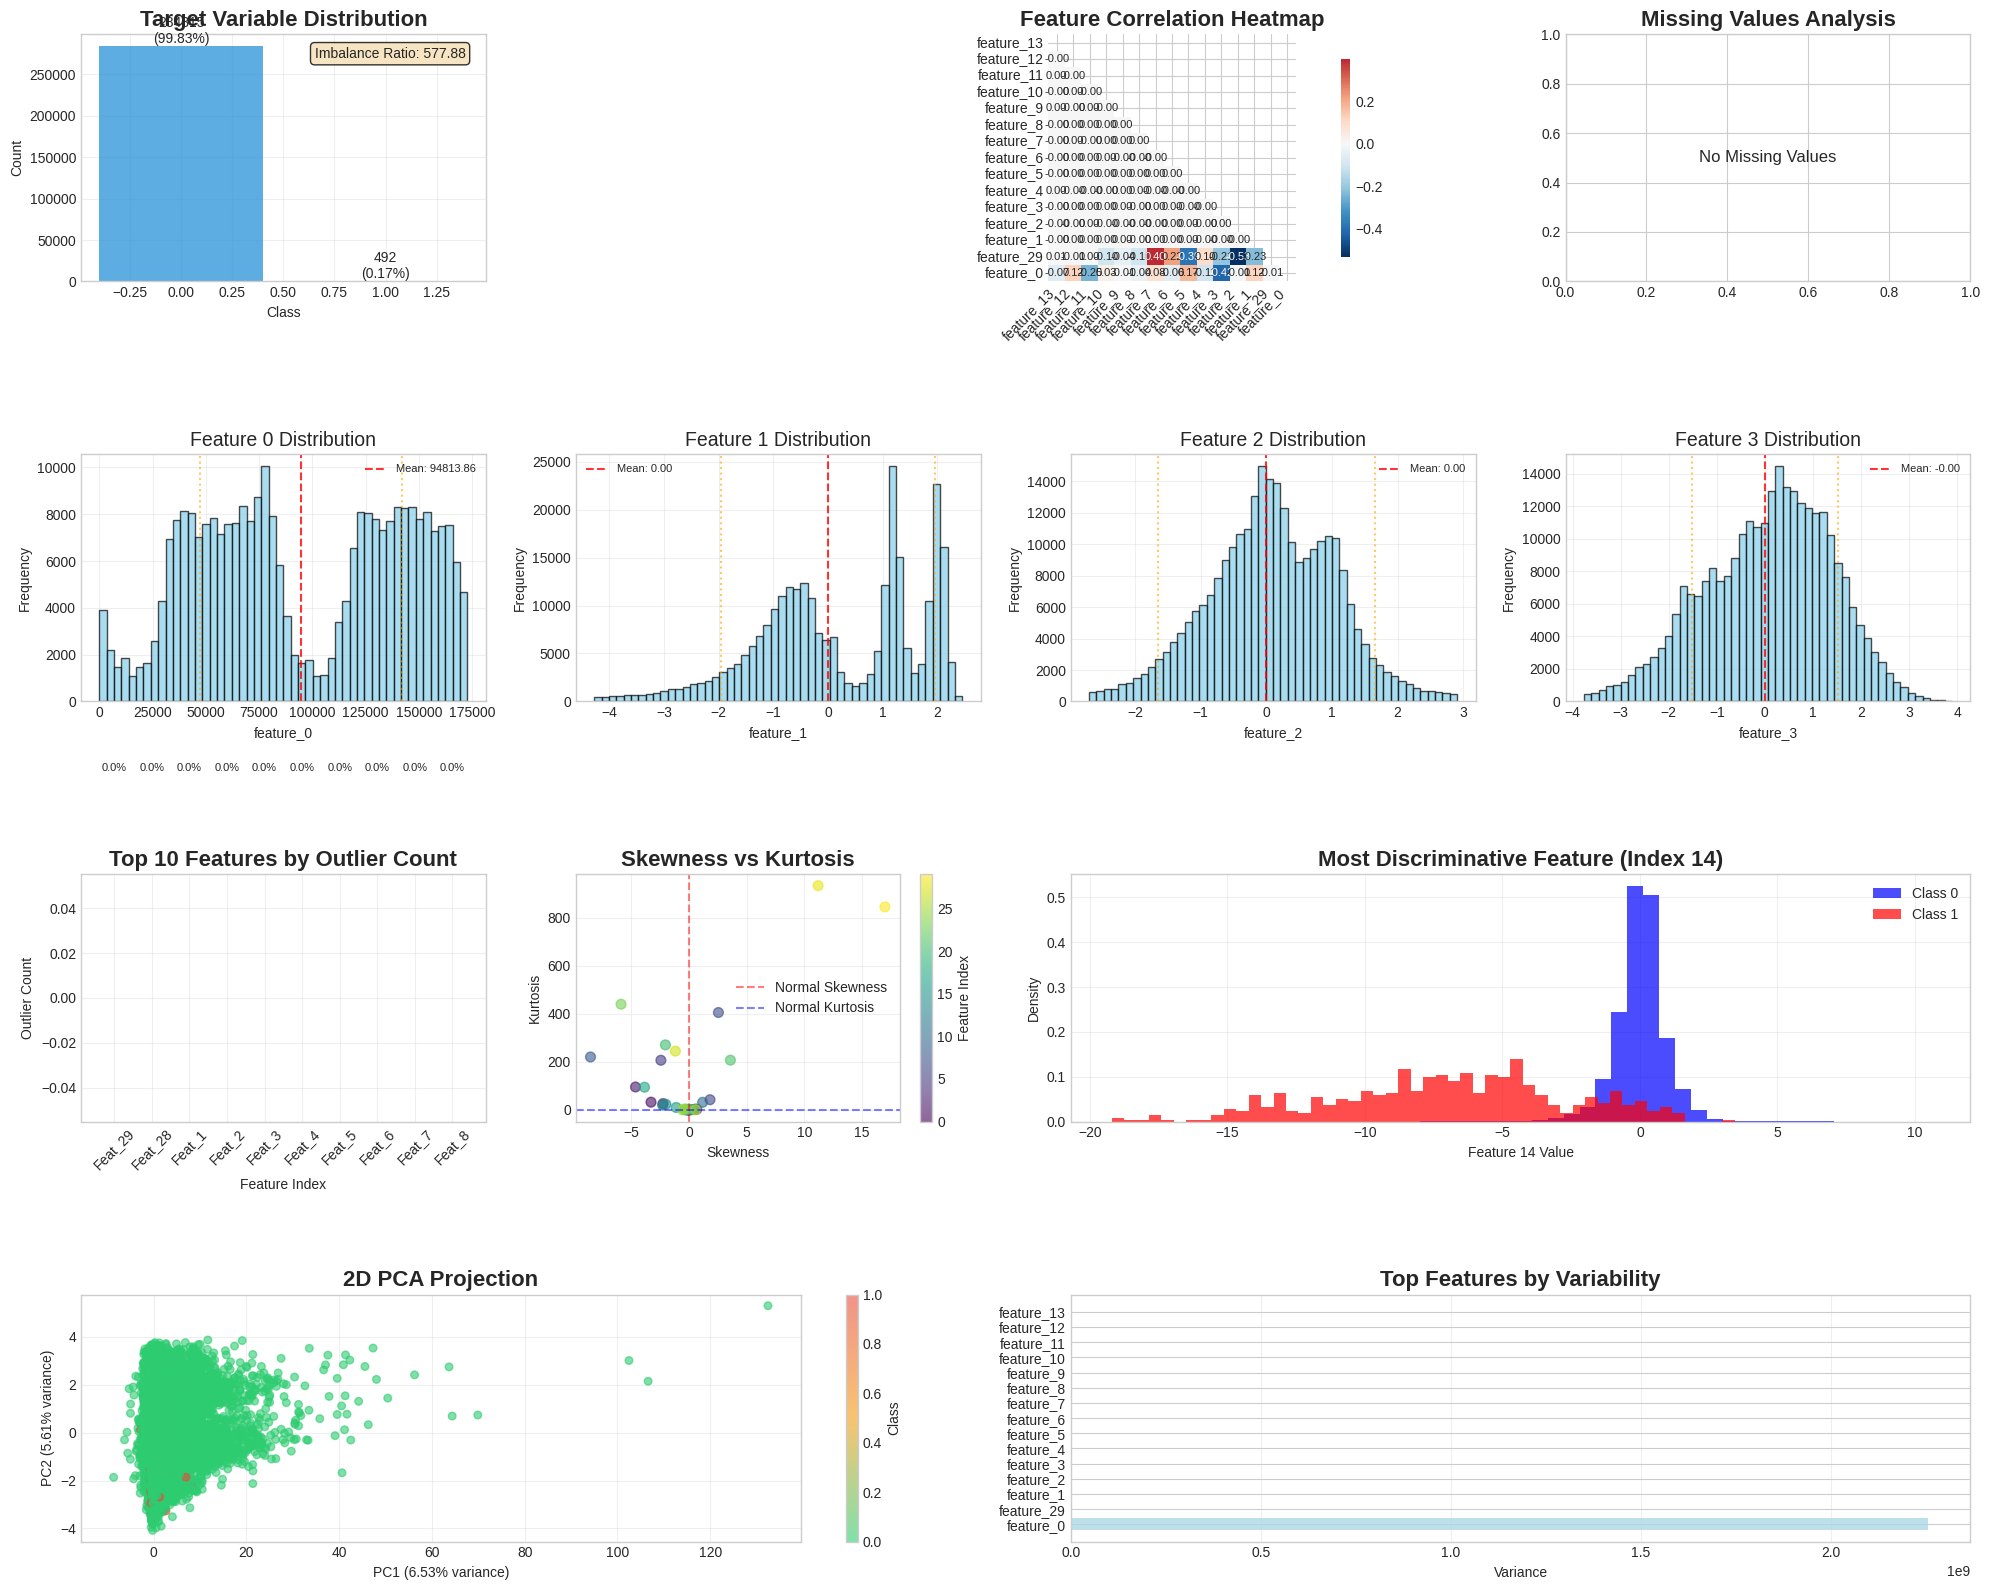

Dashboard saved to '../data/processed/eda_dashboard.png'


In [16]:
if 'feature_names' not in locals():
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]

# init visualizer
viz_config = PlotConfig(figsize=(16, 12), title_fontsize=16)
visualizer = AdvancedVisualizer(viz_config)

# create EDA dashboard
eda_fig = visualizer.create_eda_dashboard(
    X=X, 
    y=y, 
    feature_names=feature_names,
    stats=exploration_results
)
plt.show()

# save dashboard
os.makedirs('../data/processed', exist_ok=True)
eda_fig.savefig('../data/processed/eda_dashboard.png', dpi=300, bbox_inches='tight')
print("Dashboard saved to '../data/processed/eda_dashboard.png'")